# vision

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import * 
from fastai import *

The vision module of the fastai library contains all the necessary functions to define a Dataset for all the Computer Vision tasks. It contains three different submodules to reach that goal:
- [vision.image](vision.image.ipynb) contains the basic definition of an `Image` object and all the functions that are used behind the scenes to apply transformations to such an object,
- [vision.transform](vision.transform.ipynb) contains all the transforms we can use for data augmentation,
- [vision.data](vision.data.ipynb) contains the definition of `ImageDataset` as well as the utility function to easily build a `DataBunch` for Computer Vision problems.

It also contains a last module [vision.learner](vision.learner.ipynb) to help you build models with a pretrained CNN backbone and quickly get an associated `Learner` object. 

## Quick introduction to Image objects

The fastai library is built such that the pictures loaded are wrapped in an `Image`. This `Image` contains the array of pixels associated to the picture, but also has a lot of built-in functions that will help the fastai library to process transformations applied to the corresponding image.

Opening an image and converting to an `Image` object is easily done by using the `open_image` function:

In [ ]:
img = open_image('imgs/cat_example.jpg')
img

Image (torch.Size([3, 500, 394]))

To look at the picture that this `Image` contains, you can simply use its `show` method.

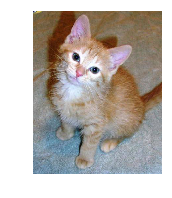

In [ ]:
img.show()

This `show` method can take a few arguments (see its documentation for details) but the two we will use the most in this documentation are:
- `ax` which is the [matplolib.pyplot axes](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.axes.html) on which we want to show the image
- `title` which is an optional title we can give to the image.

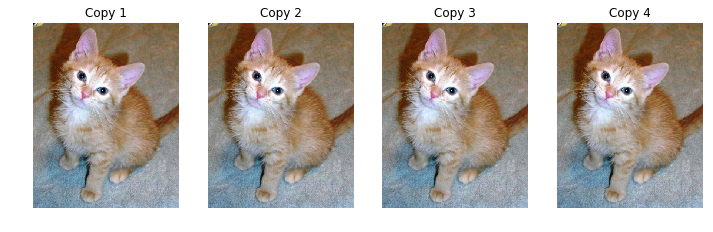

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,4))
for i,ax in enumerate(axs): img.show(ax=ax, title=f'Copy {i+1}')

If you're interested in the tensor of pixels, it's stored in the `data` attribute of an `Image`.

In [ ]:
img.data

tensor([[[0.1294, 0.0863, 0.0392,  ..., 0.4706, 0.4941, 0.4863],
         [0.0745, 0.0471, 0.0392,  ..., 0.4706, 0.4863, 0.4863],
         [0.0706, 0.0510, 0.0627,  ..., 0.4784, 0.4784, 0.4784],
         ...,
         [0.3059, 0.3647, 0.3686,  ..., 0.5412, 0.5725, 0.5725],
         [0.3294, 0.4000, 0.4039,  ..., 0.5882, 0.5765, 0.5765],
         [0.3843, 0.4627, 0.4667,  ..., 0.6471, 0.5725, 0.5725]],

        [[0.0235, 0.0000, 0.0000,  ..., 0.3490, 0.3686, 0.3725],
         [0.0000, 0.0000, 0.0000,  ..., 0.3569, 0.3725, 0.3725],
         [0.0000, 0.0000, 0.0157,  ..., 0.3647, 0.3686, 0.3686],
         ...,
         [0.3882, 0.4588, 0.4627,  ..., 0.6471, 0.6784, 0.6784],
         [0.4118, 0.4941, 0.4980,  ..., 0.6941, 0.6824, 0.6824],
         [0.4667, 0.5569, 0.5608,  ..., 0.7529, 0.6784, 0.6784]],

        [[0.0980, 0.0863, 0.1059,  ..., 0.1765, 0.2078, 0.2078],
         [0.0706, 0.0745, 0.1137,  ..., 0.1922, 0.2078, 0.2157],
         [0.1020, 0.1176, 0.1647,  ..., 0.2078, 0.2118, 0.

## Data augmentation

Data augmentation is the most important regularization technique when training a model for Computer Vision: instead of feeding the model with the same pictures every time, we do small random transformations (a bit of rotation, zoom, translation, etc...) that don't change what's inside the image (for the human eye) but change its pixel values. Models trained with data augmentation will then generalize better.

To get a set of transforms with default values that work pretty well in a wide range of tasks, we advise to use the `get_transforms` function. Depending on the nature of the images in your data, you may want to adjust a few arguments, the most important being:
- `do_flip`: if True the image is randomly flipped (default bheavior)
- `flip_vert`: if `do_flip` is True, decides if we limit the flips to horizontal flips (when False) or to horizontal and vertical flips as well as 90-degrees rotations (when True)

In [ ]:
tfms = get_transforms()
len(tfms)

2

`get_transforms` returns a tuple of two list of transforms: one for the training set and one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). This can be then passed directly to define a `DataBunch` object (see below) which is then associated with a model to begin training.

If we want to have a look at what this transforms actually do, we need to use the `apply_tfms` function. It will be in charge of picking the values of the random parameters and doing the transformation to the `Image` object. This function has multiple arguments you can customize (see its documentation for details), we will highlight here the most useful. The first one we'll need to set, especially if our images are of different shapes, is the target `size`. It will ensure all the images are cropped or padded to the same size so we can then collate them into batches.

In [ ]:
def get_ex(): return open_image('imgs/cat_example.jpg')

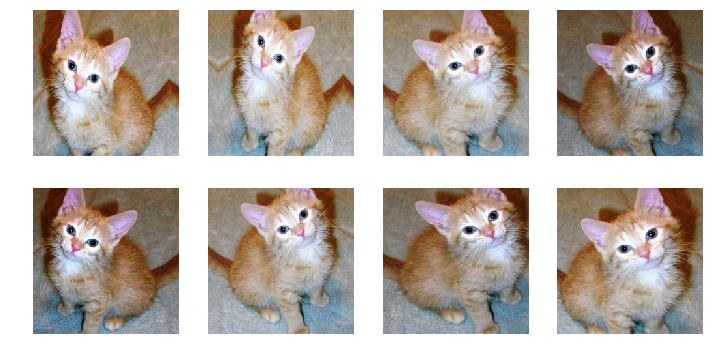

In [ ]:
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = apply_tfms(tfms[0], get_ex(), size=224)
    img.show(ax=ax)

Note that the target `size` can be a rectangle if you specify a tuple of int (height by width).

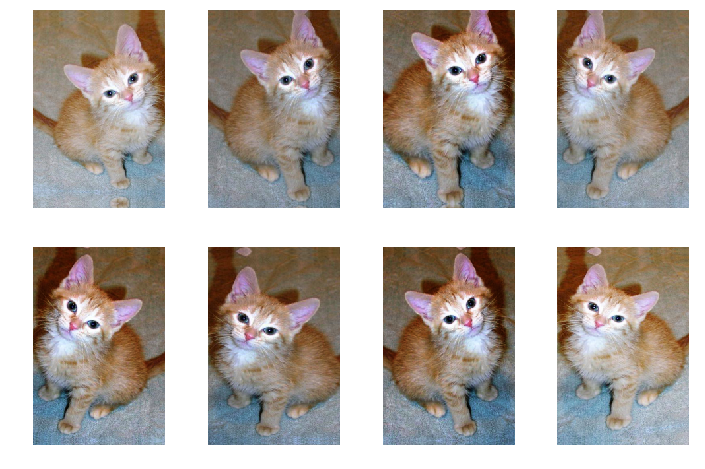

In [ ]:
_, axs = plt.subplots(2,4,figsize=(12,8))
for ax in axs.flatten():
    img = apply_tfms(tfms[0], get_ex(), size=(300,200))
    img.show(ax=ax)

The second argument that can be customized is how we treat missing pixels: when applying transforms (like a rotation), some of the pixels inside the square won't have values from the image. We can decide to have them:
- black (`padding_mode`='zeros')
- the value of the one at the nearest border (`padding_mode`='border')
- the value of the one symmetric according to the nearest borer (`padding_mode`='reflect')

The last one is the default behavior, here is what the two other look like:

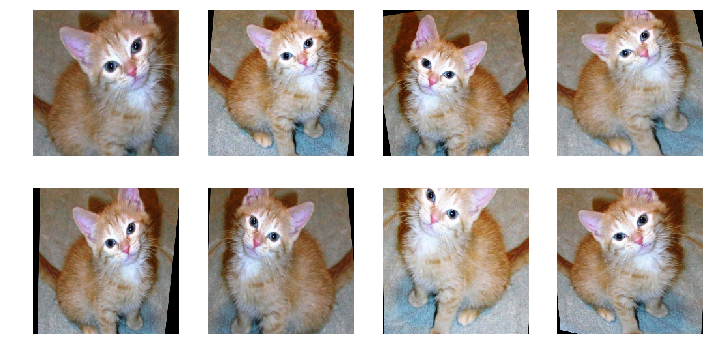

In [ ]:
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = apply_tfms(tfms[0], get_ex(), size=224, padding_mode='zeros')
    img.show(ax=ax)

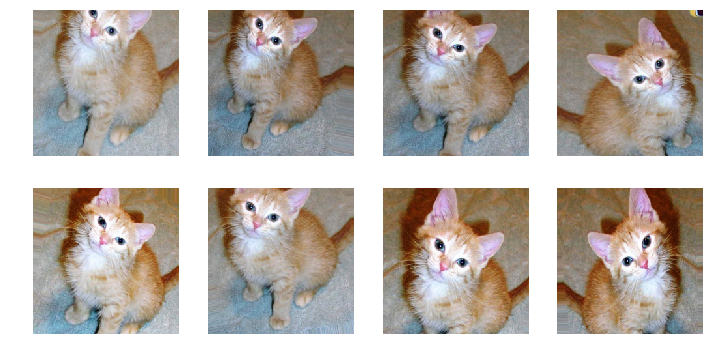

In [ ]:
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = apply_tfms(tfms[0], get_ex(), size=224, padding_mode='border')
    img.show(ax=ax)

The third argument that might be useful to change is `do_crop`. Images are often rectangles of different ratios, so to get them to the target `size`, we can either take a random crop from the result of our transforms (which is the default behavior), or add padding on the side that needs to get bigger.

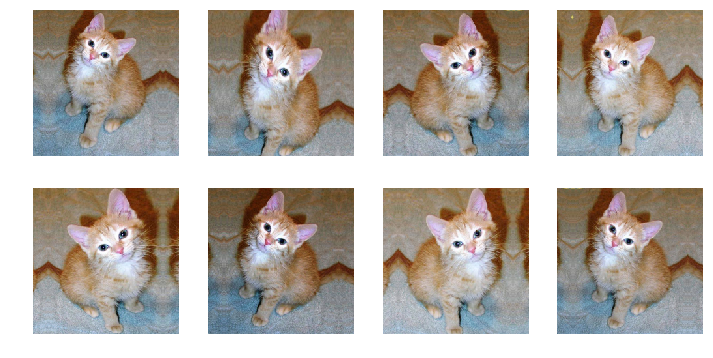

In [ ]:
_, axs = plt.subplots(2,4,figsize=(12,6))
for ax in axs.flatten():
    img = apply_tfms(tfms[0], get_ex(), size=224, do_crop=False)
    img.show(ax=ax)

## Quickly get your data ready for training

To get you started as easily as possible, the fastai provides two helper functions to create a `DataBunch` object that you can directly use for training a classifier. To demonstrate them you'll first need to untar the file by executing the following cell (uncomment as needed). This will create a data folder containing a MNIST subset in 'data/mnist_sample'.

In [ ]:
#import tarfile
#tarfile.open('../data/mnist_sample.tgz', 'r:gz').extractall('../data/')

The first way to define a `DataBunch` object requires you to put your data in folders this way (test being optional):
```
path\
  train\
    clas1\
    clas2\
    ...
    clasn\
  valid\
    clas1\
    clas2\
    ...
    clasn\
  test\
```
You can then use `image_data_from_folder`:

In [ ]:
data = image_data_from_folder('../data/mnist_sample/', ds_tfms=get_transforms(), tfms=imagenet_norm, size=24, num_workers=0)

As all `DataBunch`, data then as a `train_dl` and a `valid_dl` that are `DataLoader`. If you want to have a look at a few images in a batch inside a batch, you can use `show_image_batch`. 

In [ ]:
show_image_batch(data.train_dl, data.train_ds.classes, rows = 4)

ValueError: padding_mode needs to be 'zeros' or 'border', but got reflection

Here the datasets will be automatically created from the structure above, and we precise:
- the transforms to apply to the images in `ds_tfms`,
- the transformation to apply to the batches (here just normaliazion) in `tfms`,
- the target `size` of ouy pictures.

The second way to define the data for a classifier requires a structure like this:
```
path\
  train\
  test\
  labels.csv
```
where the labels.csv file precise what the label(s) of each image in the training set. You can then use `image_data_from_csv`:

In [ ]:
data = image_data_from_csv('path', ds_tfms=get_transforms(), tfms=imagenet_norm, size=224)

Note that the fastai library will automatically analyze the labels to determine if this is a multi-classification problem or not and use the appropriate type of dataset.